In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
import random
import seaborn as sns
from sklearn.cluster import KMeans

### Looking at the dataframe and how to impute any missing values
in the below lines of code, I take the "all merged" dataset, and then select only the
columns relevant to the "product" table. From there, I fill in the missing values of the
"count" column with ones, and then sum the counts for otherwise duplicate rows. After that, 
I drop the duplicates.

In [2]:
df = pd.read_csv('../all_merged_data.csv')
df = df[['user_id', 'product_id', 'date_order', 'application_term', 'limit', 
    'result', 'city_id_product', 'bank_id', 'product_type_product', 
    'guarantee_type_product', 'loan_term_min', 'loan_term_max', 'loan_term_type', 
    'decision_cycle', 'loan_cycle', 'repayment_type', 'loan_quota_min', 'loan_quota_max',
    'interest_rate_type', 'guarantee_required', 'standard_type_product', 'apply_num', 
    'fangkuan_num', 'is_p2p', 'id', 'house_register', 'business_license', 'legal_person',
    'married', 'car', 'income', 'house', 'tax', 'socialsecurity', 'bank', 'lifecost', 
    'early_repayment', 'penalty', 'counts']]
df['counts'] = df['counts'].fillna(1)
df = df.fillna(-1)
df = df.groupby(['user_id', 'product_id', 'date_order', 'application_term', 'limit', 
    'result', 'city_id_product', 'bank_id', 'product_type_product', 
    'guarantee_type_product', 'loan_term_min', 'loan_term_max', 'loan_term_type', 
    'decision_cycle', 'loan_cycle', 'repayment_type', 'loan_quota_min', 'loan_quota_max',
    'interest_rate_type', 'guarantee_required', 'standard_type_product', 'apply_num', 
    'fangkuan_num', 'is_p2p', 'id', 'house_register', 'business_license', 'legal_person',
    'married', 'car', 'income', 'house', 'tax', 'socialsecurity', 'bank', 'lifecost', 
    'early_repayment', 'penalty']).agg({'counts':'sum'}).reset_index()
df = df.drop_duplicates()

### Two columns with missing values: early_repayment and penalty
Contingency tables below show there may be a dependence of result on 
the missingness. Earlier I had imputed the missing values as "-1"

In [3]:
df.groupby('early_repayment')['result'].value_counts(normalize=True).\
    rename('values').reset_index().pivot(index='result', columns='early_repayment', 
            values='values').rename(columns={-1:np.nan})

early_repayment,NaN,0.0,1.0
result,,,
0,0.903406,0.873016,0.794402
1,0.096594,0.126984,0.205598


In [4]:
df.groupby('penalty')['result'].value_counts(normalize=True).\
    rename('values').reset_index().pivot(index='result',columns='penalty', 
        values='values').rename(columns={-1:np.nan})

penalty,NaN,0.0,1.0
result,,,
0,0.903158,0.856266,0.781857
1,0.096842,0.143734,0.218143


The following shows that the "counts" column is NOT the same as the "apply_num" column

In [5]:
print((df.apply_num == df.counts).sum(), (df.apply_num != df.counts).sum())

530 142508


### Set up for random forest classifier for "result"

In [6]:
rfc = RandomForestClassifier()

In [7]:
## I drop the categorical variables that seem to hold limited info
features_counts = df.drop(['user_id','product_id','bank_id','city_id_product', 
                           'apply_num', 'result'], axis=1)
results = df['result']

In [8]:
gridparams_rfc = {'max_features': range(4,9,2), 
               'n_estimators': range(40,150,20)}   
gridsearch_rfc = GridSearchCV(rfc, gridparams_rfc, cv=5, 
                           scoring='balanced_accuracy', n_jobs=-1)

In [9]:
gridsearch_rfc.fit(features_counts, results)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

{'max_features': 8, 'n_estimators': 100}
0.5801757564072516


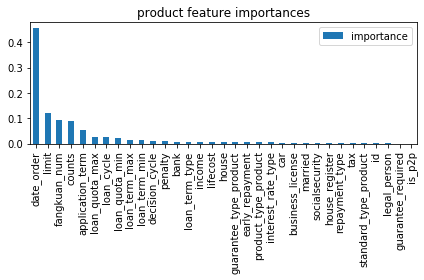

In [10]:
print(gridsearch_rfc.best_params_)
print(gridsearch_rfc.best_score_)
best_est = gridsearch_rfc.best_estimator_
df_features_result_counts = pd.DataFrame(best_est.feature_importances_, 
    index=features_counts.columns, columns=['importance'])
df_features_result_counts.sort_values(by='importance', ascending=False).plot.bar()
plt.title('product feature importances')
plt.tight_layout()
plt.show()

In [11]:
best_est.fit(features_counts, results)
print(best_est.score(features_counts, results))

0.9927501782743048


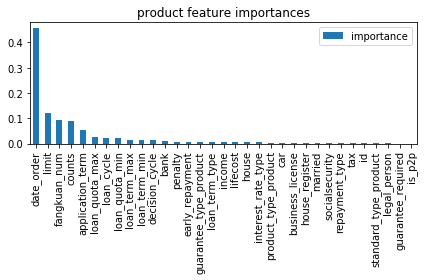

In [12]:
df_features_result_counts2 = pd.DataFrame(best_est.feature_importances_, 
    index=features_counts.columns, columns=['importance'])
df_features_result_counts2.sort_values(by='importance', ascending=False).plot.bar()
plt.title('product feature importances')
plt.tight_layout()
plt.show()

In [13]:
features_applynum = df.drop(['user_id','product_id','bank_id','city_id_product', 
                           'counts', 'result'], axis=1)

In [14]:
gridsearch_rfc.fit(features_applynum, results)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

{'max_features': 8, 'n_estimators': 120}
0.5843642693556845


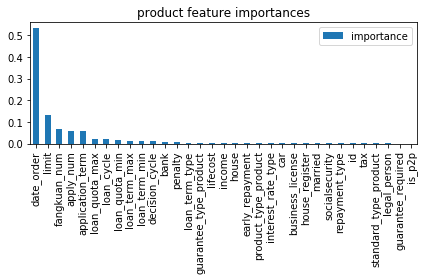

In [15]:
print(gridsearch_rfc.best_params_)
print(gridsearch_rfc.best_score_)
best_est = gridsearch_rfc.best_estimator_
df_features_result_applynum = pd.DataFrame(best_est.feature_importances_, 
    index=features_applynum.columns, columns=['importance'])
df_features_result_applynum.sort_values(by='importance', ascending=False).plot.bar()
plt.title('product feature importances')
plt.tight_layout()
plt.show()

In [16]:
best_est.fit(features_applynum, results)
print(best_est.score(features_applynum, results))

0.9889050462114962


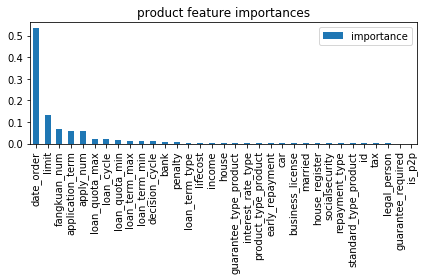

In [17]:
df_features_result_applynum2 = pd.DataFrame(best_est.feature_importances_, 
    index=features_applynum.columns, columns=['importance'])
df_features_result_applynum2.sort_values(by='importance', ascending=False).plot.bar()
plt.title('product feature importances')
plt.tight_layout()
plt.show()

## Random Forest to determine Apply_num

In [18]:
## for the features I drop the categorical variables that seem to hold limited info
features = df.drop(['user_id','product_id','bank_id','city_id_product', 
                           'apply_num', 'counts'], axis=1)
counts_target = df['counts']
applynum_target = df['apply_num']

In [19]:
rfr = RandomForestRegressor()

In [21]:
gridparams_rfr = { 'max_features': range(2,11,2),
               'n_estimators': range(60,300,30)} 
gridsearch_rfr = GridSearchCV(rfr, gridparams_rfr, cv=5, 
                           scoring='r2', n_jobs=-1)

In [22]:
gridsearch_rfr.fit(features, counts_target)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_features': range(2, 11, 2),


{'max_features': 6, 'n_estimators': 180}
-0.15783887840053193


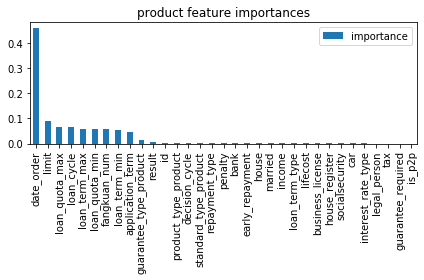

In [23]:
print(gridsearch_rfr.best_params_)
print(gridsearch_rfr.best_score_)
best_est = gridsearch_rfr.best_estimator_
df_rfr_counts = pd.DataFrame(best_est.feature_importances_, 
    index=features.columns, columns=['importance'])
df_rfr_counts.sort_values(by='importance', ascending=False).plot.bar()
plt.title('product feature importances')
plt.tight_layout()
plt.show()

In [24]:
best_est.fit(features, counts_target)
print(best_est.score(features, counts_target)) # 8 range(2,10,1), 250 range(100,301,50)

0.8537029294896091


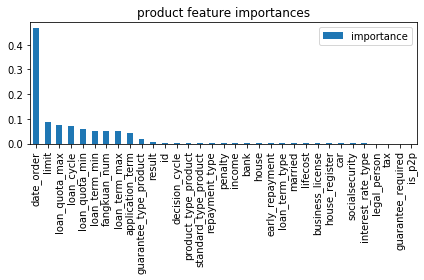

In [25]:
df_rfr_counts2 = pd.DataFrame(best_est.feature_importances_, 
    index=features.columns, columns=['importance'])
df_rfr_counts2.sort_values(by='importance', ascending=False).plot.bar()
plt.title('product feature importances')
plt.tight_layout()
plt.show()

In [26]:
gridsearch_rfr.fit(features, applynum_target)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_features': range(2, 11, 2),


{'max_features': 10, 'n_estimators': 210}
0.9999700392371713


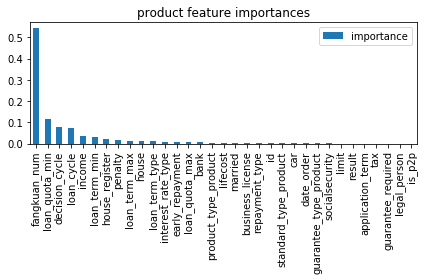

In [27]:
print(gridsearch_rfr.best_params_)
print(gridsearch_rfr.best_score_)
best_est = gridsearch_rfr.best_estimator_
df_rfr_applynum = pd.DataFrame(best_est.feature_importances_, 
    index=features.columns, columns=['importance'])
df_rfr_applynum.sort_values(by='importance', ascending=False).plot.bar()
plt.title('product feature importances')
plt.tight_layout()
plt.show()

In [28]:
best_est.fit(features, applynum_target)
print(best_est.score(features, applynum_target))

0.9999953612111653


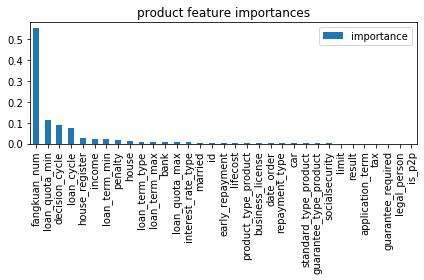

In [29]:
df_rfr_applynum2 = pd.DataFrame(best_est.feature_importances_, 
    index=features.columns, columns=['importance'])
df_rfr_applynum2.sort_values(by='importance', ascending=False).plot.bar()
plt.title('product feature importances')
plt.tight_layout()
plt.show()

### Clustering

In [31]:
kmeans = KMeans()

                          counts  counts_bestest  applynum  applynum_bestest
date_order              0.458241        0.466981  0.001151          0.002484
limit                   0.091515        0.088403  0.000135          0.000177
loan_quota_max          0.066879        0.074134  0.007265          0.006403
loan_cycle              0.065790        0.070053  0.074931          0.075924
loan_term_max           0.059545        0.049380  0.013204          0.007948
loan_quota_min          0.059417        0.060488  0.114372          0.112040
fangkuan_num            0.057324        0.052349  0.543465          0.553535
loan_term_min           0.053947        0.052675  0.028773          0.022104
application_term        0.044060        0.040755  0.000064          0.000074
guarantee_type_product  0.015882        0.016608  0.000495          0.000546
result                  0.007133        0.006796  0.000108          0.000140
id                      0.003502        0.003889  0.002269          0.004405

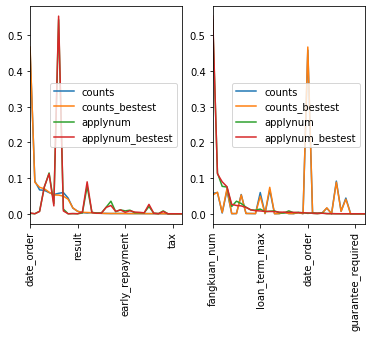

In [32]:
feature_importances = pd.concat([df_rfr_counts.rename(columns={"importance":"counts"}), 
                        df_rfr_counts2.rename(columns={"importance":"counts_bestest"}), 
                        df_rfr_applynum.rename(columns={"importance":"applynum"}), 
                        df_rfr_applynum2.rename(columns={"importance":
                                            "applynum_bestest"})], axis=1)

f, (ax1, ax2) = plt.subplots(1, 2)
feature_importances.sort_values(by="counts_bestest", ascending=False).plot(ax = ax1)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)
feature_importances.sort_values(by="applynum_bestest", ascending=False).plot(ax=ax2)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=90)
print(feature_importances.sort_values(by="counts", ascending=False))
print(feature_importances.sort_values(by="applynum", ascending=False))

In [33]:
features_counts = df[feature_importances.sort_values(by="counts_bestest", 
                    ascending=False)[:15].index.tolist() + ['counts']]
#features_counts = df[['date_order', 'limit', 'loan_quota_min',  'loan_cycle', 'loan_term_max',
#    'loan_term_min', 'fangkuan_num', 'application_term', 'guarantee_type_product', 'result', 
#    'decision_cycle', 'id', 'standard_type_product', 'product_type_product', 'counts']]

In [56]:
#features_counts = df[['date_order', 'limit', 'loan_quota_min',  'loan_cycle', 'loan_term_max',
#    'loan_term_min', 'fangkuan_num', 'application_term', 'guarantee_type_product', 'result', 
#    'decision_cycle', 'id', 'standard_type_product', 'product_type_product', 'counts']]

In [57]:
for column in features_counts.columns:
    print(column)
    if (features_counts[column].nunique() < 10) and (features_counts[column].nunique() > 2):
        print(features_counts[column].value_counts())
        features_counts = pd.concat([features_counts, 
                pd.get_dummies(features_counts[column], prefix=column)], axis=1)

date_order
limit
loan_quota_min
loan_cycle
loan_term_max
loan_term_min
fangkuan_num
application_term
guarantee_type_product
2    120181
1     14804
4      5082
3      1256
6      1194
0       280
5       241
Name: guarantee_type_product, dtype: int64
result
decision_cycle
id
standard_type_product
product_type_product
6      90690
100    29905
1      16581
5       3062
3       1762
2        633
4        356
102       29
101       20
Name: product_type_product, dtype: int64
counts


In [58]:
counts_matrix = StandardScaler().fit_transform(features_counts.\
                    drop(['guarantee_type_product','product_type_product'], axis=1))

In [59]:
def plot_inertia(km, X, n_cluster_range):
    inertias = []
    for i in n_cluster_range:
        km.set_params(n_clusters=i)
        km.fit(X)
        inertias.append(km.inertia_)
    plt.plot(n_cluster_range, inertias, marker='o')
    plt.title('Elbow method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.show()

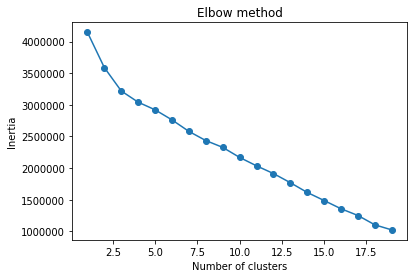

In [60]:
plot_inertia(kmeans, counts_matrix, range(1,20))

In [61]:
kmeans3 = KMeans().set_params(n_clusters=3)

In [62]:
kmeans3.fit(counts_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [63]:
pd.Series(kmeans3.labels_).value_counts()

2    97624
0    29879
1    15535
dtype: int64

In [64]:
features_counts['kmeans_group'] = kmeans3.labels_

In [65]:
df['kmeans_group'] = kmeans3.labels_

In [66]:
df.to_csv('grouped_products.csv', index=False)
features_counts.to_csv('features_counts.csv', index=False)

In [67]:
numerical_col = []
categorical_col = []
for column in df.columns:
    if column in ['bank_id','user_id','product_id', 'city_id_product']: continue
    print(column)
    print(df[column].nunique())
    if df[column].nunique() > 10:
        numerical_col.append(column)
    else: categorical_col.append(column)
print(len(numerical_col))
print(len(categorical_col))

date_order
793
application_term
60
limit
420
result
2
product_type_product
9
guarantee_type_product
7
loan_term_min
18
loan_term_max
55
loan_term_type
2
decision_cycle
17
loan_cycle
42
repayment_type
4
loan_quota_min
42
loan_quota_max
77
interest_rate_type
3
guarantee_required
2
standard_type_product
2
apply_num
703
fangkuan_num
312
is_p2p
1
id
2
house_register
2
business_license
2
legal_person
2
married
2
car
2
income
2
house
2
tax
2
socialsecurity
2
bank
2
lifecost
2
early_repayment
3
penalty
3
counts
287
kmeans_group
3
12
24


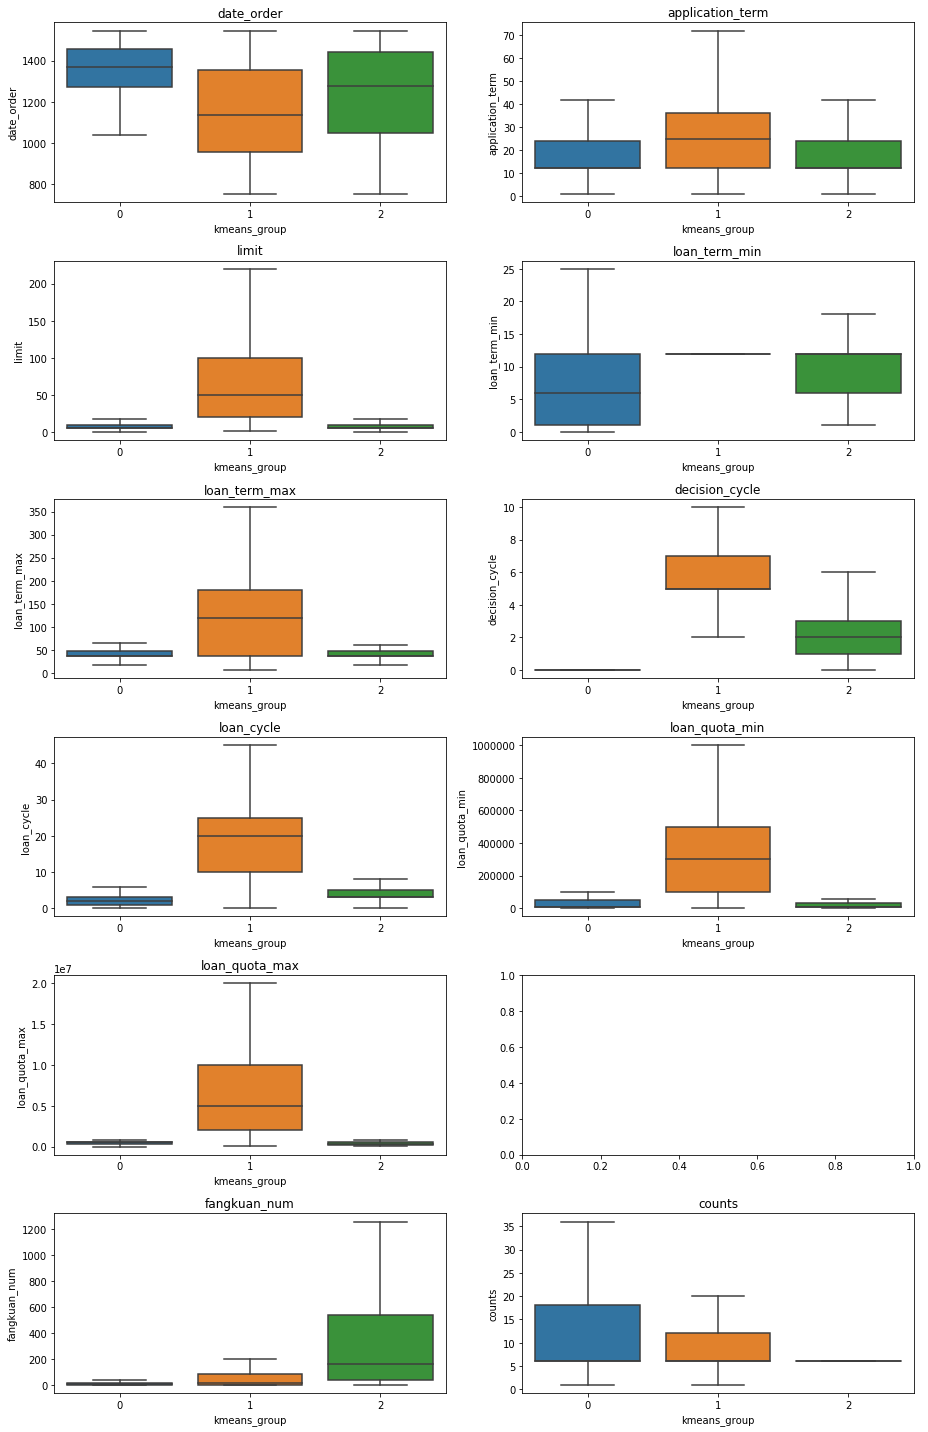

In [70]:
f, axes = plt.subplots(6,2, figsize=(13, 20))
for i, column in enumerate(numerical_col):
    if column == 'apply_num': continue
    sns.boxplot(x='kmeans_group', y=column, data=df,
                ax=axes[i//2][i%2], showfliers=False)
    axes[i//2][i%2].set_title(column)
plt.tight_layout()

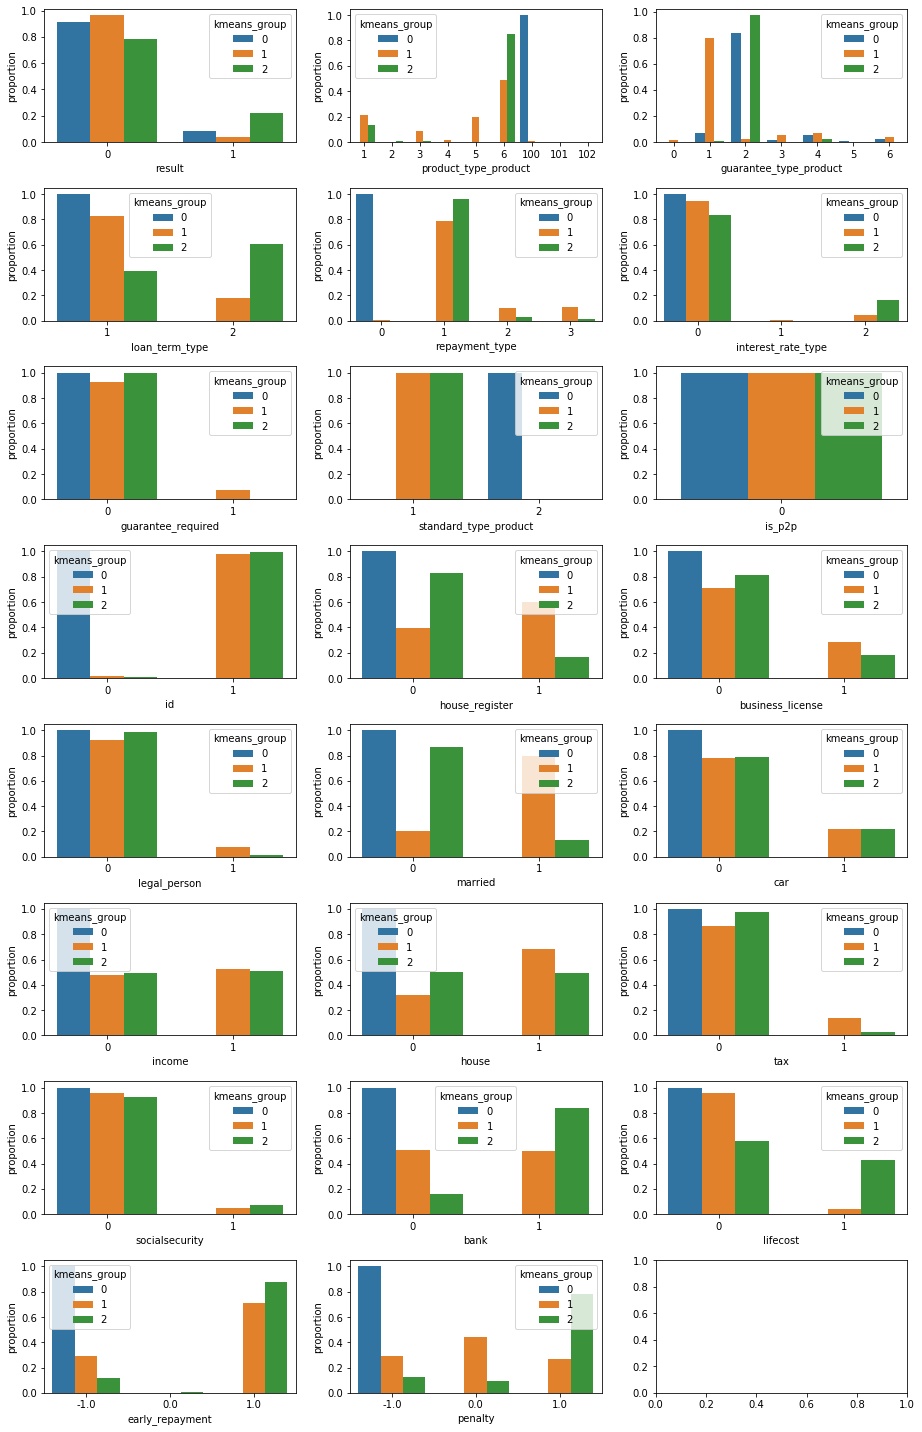

In [72]:
f, axes = plt.subplots(8,3, figsize=(13, 20))
for i, column in enumerate(categorical_col):
    if column == 'kmeans_group': continue
    plotdf = df.groupby('kmeans_group')[column].\
        value_counts(normalize=True).rename('proportion').reset_index()
    sns.barplot(x=column, y= 'proportion', hue='kmeans_group', data = plotdf, ax=axes[i//3][i%3])
plt.tight_layout()

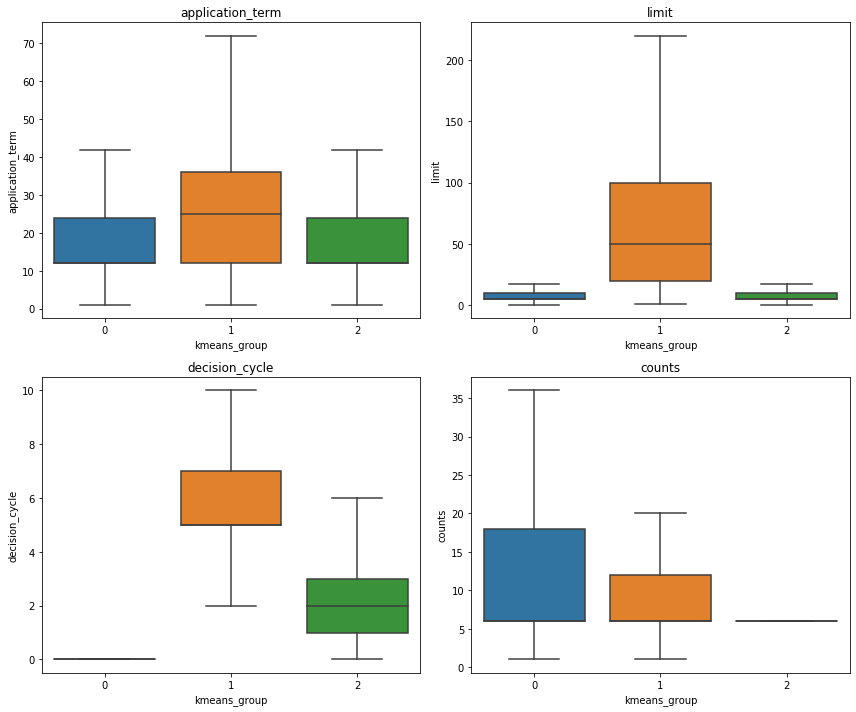

In [77]:
f, axes = plt.subplots(2,2, figsize=(12, 10))
for i, column in enumerate(['application_term','limit', 'decision_cycle', 'counts']):
    sns.boxplot(x='kmeans_group', y=column, data=df,
                ax=axes[i//2][i%2], showfliers=False)
    axes[i//2][i%2].set_title(column)
plt.tight_layout()

In [78]:
print(categorical_col)

['result', 'product_type_product', 'guarantee_type_product', 'loan_term_type', 'repayment_type', 'interest_rate_type', 'guarantee_required', 'standard_type_product', 'is_p2p', 'id', 'house_register', 'business_license', 'legal_person', 'married', 'car', 'income', 'house', 'tax', 'socialsecurity', 'bank', 'lifecost', 'early_repayment', 'penalty', 'kmeans_group']


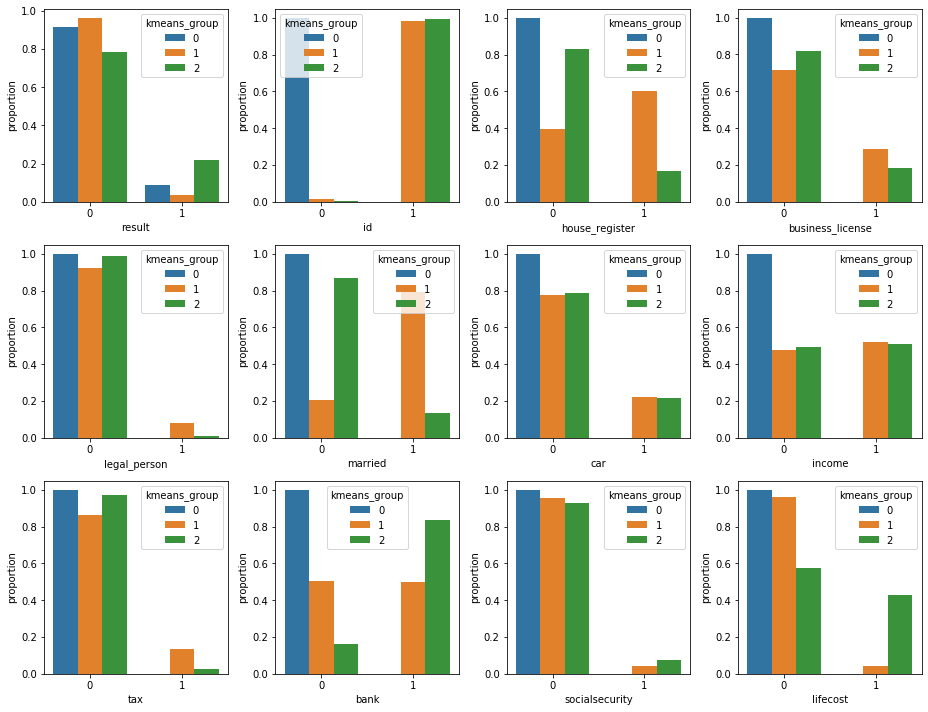

In [88]:
f, axes = plt.subplots(3,4, figsize=(13, 10))
for i, column in enumerate(['result','id','house_register', 'business_license',#'house',
                            'legal_person', 'married', 'car', 'income', 'tax', 'bank',#]):
                            'socialsecurity', 'lifecost']):
    if column == 'kmeans_group': continue
    plotdf = df.groupby('kmeans_group')[column].\
        value_counts(normalize=True).rename('proportion').reset_index()
    sns.barplot(x=column, y= 'proportion', hue='kmeans_group', data = plotdf, ax=axes[i//4][i%4])
plt.tight_layout()

## PCA

In [89]:
from sklearn.decomposition import PCA

In [93]:
df.columns

Index(['user_id', 'product_id', 'date_order', 'application_term', 'limit',
       'result', 'city_id_product', 'bank_id', 'product_type_product',
       'guarantee_type_product', 'loan_term_min', 'loan_term_max',
       'loan_term_type', 'decision_cycle', 'loan_cycle', 'repayment_type',
       'loan_quota_min', 'loan_quota_max', 'interest_rate_type',
       'guarantee_required', 'standard_type_product', 'apply_num',
       'fangkuan_num', 'is_p2p', 'id', 'house_register', 'business_license',
       'legal_person', 'married', 'car', 'income', 'house', 'tax',
       'socialsecurity', 'bank', 'lifecost', 'early_repayment', 'penalty',
       'counts', 'kmeans_group'],
      dtype='object')

In [98]:
df_pca = df.drop(['user_id', 'product_id', 'city_id_product', 'bank_id', 'kmeans_group'], axis=1)

In [100]:
for column in df_pca.columns:
    if (df_pca[column].nunique() < 10) and (df_pca[column].nunique() > 2):
        df_pca = pd.concat([df_pca.drop(column, axis=1), pd.get_dummies(df_pca[column], prefix=column)], axis=1)
#pca.set_params(n_components=3)
#pca.fit(df.drop(['user_id', 'product_id', ]))

In [101]:
matrix_pca = StandardScaler().fit_transform(df_pca)

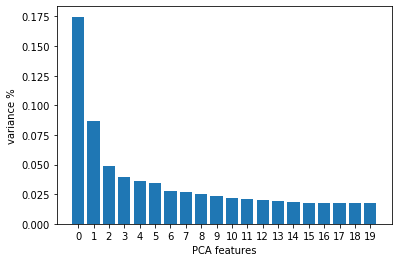

In [103]:
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(matrix_pca)
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_)#, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

Text(0, 0.5, 'PCA 2')

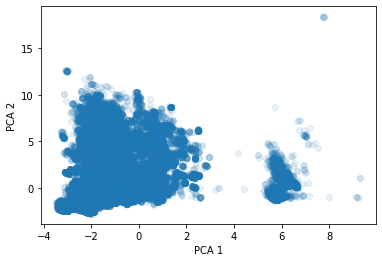

In [104]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1)#, color='black')
plt.xlabel('0')
plt.ylabel('PCA 2')

In [107]:
PCA_components['kmeans_group'] = df['kmeans_group']

Text(0, 0.5, 'PCA 2')

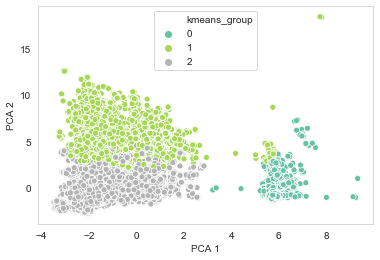

In [110]:
sns.scatterplot(x=0, y=1, hue='kmeans_group', style=None, 
                size=None, data=PCA_components, palette="Set2", hue_order=None, 
                hue_norm=None, sizes=None, size_order=None, size_norm=None, 
                markers=True, style_order=None, x_bins=None, y_bins=None, units=None, 
                estimator=None, ci=95, n_boot=1000, alpha='auto', x_jitter=None, y_jitter=None, 
                legend='brief', ax=None)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

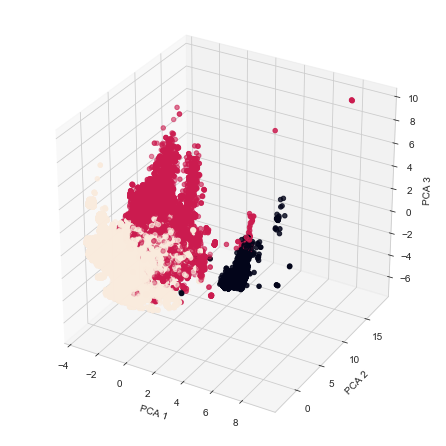

In [111]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(6,6))
sns.set_style("whitegrid", {'axes.grid' : False})
ax = Axes3D(fig) # Method 1
# ax = fig.add_subplot(111, projection='3d') # Method 2

#x = np.random.uniform(1,20,size=20)
#y = np.random.uniform(1,100,size=20)
#z = np.random.uniform(1,100,size=20)


ax.scatter(PCA_components[0], PCA_components[1], PCA_components[2], c=PCA_components['kmeans_group'], marker='o')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')

plt.show()

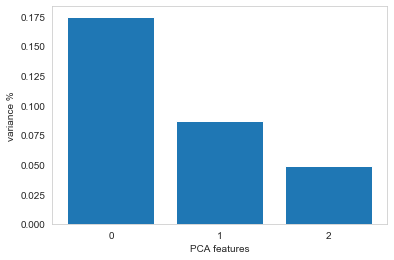

In [113]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(matrix_pca)
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_)#, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

In [114]:
PCA_components['kmeans_group'] = df['kmeans_group']

Text(0, 0.5, 'PCA 2')

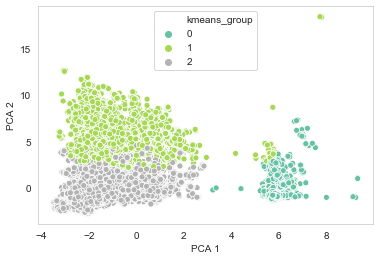

In [115]:
sns.scatterplot(x=0, y=1, hue='kmeans_group', style=None, 
                size=None, data=PCA_components, palette="Set2", hue_order=None, 
                hue_norm=None, sizes=None, size_order=None, size_norm=None, 
                markers=True, style_order=None, x_bins=None, y_bins=None, units=None, 
                estimator=None, ci=95, n_boot=1000, alpha='auto', x_jitter=None, y_jitter=None, 
                legend='brief', ax=None)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

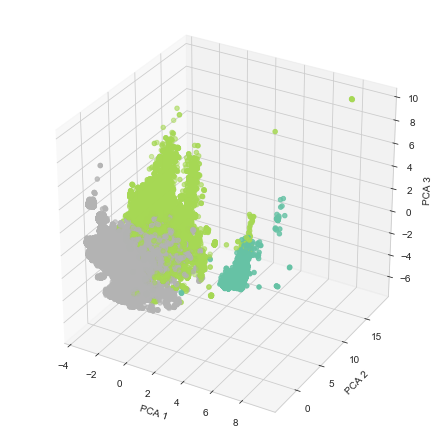

In [123]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(6,6))
sns.set_style("whitegrid", {'axes.grid' : False})
ax = Axes3D(fig) 

ax.scatter(PCA_components[0], PCA_components[1], PCA_components[2], c=PCA_components['kmeans_group'], 
           cmap=plt.cm.Set2, marker='o')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')

plt.show()